### Exploratory Data Analysis for Movie data

In [102]:
# Make the chunk output all results not only the last result
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [170]:
# Import libraries
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import json
import ast
import shap
from urllib.request import urlopen
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hongyang.zheng\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [53]:
# Load data
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

# Look at the data
train.head(10)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970
5,6,NaN,8000000,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",NaN,tt0093743,en,Pinocchio and the Emperor of the Night,"Pinocchio and his friends, a glow worm and a m...",0.743274,...,8/6/87,83.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Pinocchio and the Emperor of the Night,NaN,"[{'cast_id': 6, 'character': 'Pinocchio (voice...","[{'credit_id': '52fe46f49251416c9106558b', 'de...",3261638
6,7,NaN,14000000,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",http://www.thepossessionmovie.com/,tt0431021,en,The Possession,A young girl buys an antique box at a yard sal...,7.286477,...,8/30/12,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Fear The Demon That Doesn't Fear God,The Possession,NaN,"[{'cast_id': 23, 'character': 'Clyde', 'credit...","[{'credit_id': '52fe4981c3a368484e12ee29', 'de...",85446075
7,8,NaN,0,"[{'id': 99, 'name': 'Documentary'}]",NaN,tt0391024,en,Control Room,A chronicle which provides a rare window into ...,1.949044,...,1/15/04,84.0,"[{'iso_639_1': 'ar', 'name': 'العربية'}, {'iso...",Released,Different channels. Different truths.,Control Room,"[{'id': 917, 'name': 'journalism'}, {'id': 163...","[{'cast_id': 2, 'character': 'Himself', 'credi...","[{'credit_id': '52fe47a69251416c750a0daf', 'de...",2586511
8,9,"[{'id': 256377, 'name': 'The Muppet Collection...",0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",NaN,tt0117110,en,Muppet Treasure Island,After telling the story of Flint's last journe...,6.902423,...,2/16/96,100.0,"[{'

In [54]:
# Look at the shape of train data
train.shape

# Look at the shape of test data
test.shape

(3000, 23)

The train dataset only has 3000 observations, which is smaller than the test dataset. I think this will make training an accurate model much harder.

In [56]:
# Print out the columns name
train.columns.values

array(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'Keywords',
       'cast', 'crew', 'revenue'], dtype=object)

### Preprocess columns

First convert some json columns into dictionaries.


In [65]:
# Write a function to do this for both train and test dataset
def convert_json(df):
    columns_need_convert=['belongs_to_collection', 'genres', 'production_companies',
                          'production_countries', 'spoken_languages', 'Keywords', 
                          'cast', 'crew']
    for name in columns_need_convert:
        df[name]=df[name].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x))
    
    return(df)

train=convert_json(train)
test=convert_json(test)

Some columns have one or more dictionaries, so the first step is to extract meaningful values from it.
#### *belongs_to_collection*

In [76]:
# Look at this column
train.belongs_to_collection.head()

0    [{'id': 313576, 'name': 'Hot Tub Time Machine ...
1    [{'id': 107674, 'name': 'The Princess Diaries ...
2                                                   {}
3                                                   {}
4                                                   {}
Name: belongs_to_collection, dtype: object

In [113]:
# Create a new column to store the name of the collection
train['collection']=train["belongs_to_collection"].apply(lambda x: x[0]['name'] if x!={} else np.nan)
test['collection']=test["belongs_to_collection"].apply(lambda x: x[0]['name'] if x!={} else np.nan)

# Other operations
train['n_collection']=train["belongs_to_collection"].apply(lambda x: len(x) if x!={} else 0)
test['n_collection']=test["belongs_to_collection"].apply(lambda x: len(x) if x!={} else 0)

In [112]:
# Look at the new columns
train.collection.head()
train.n_collection.head()

# Count the collection
sum(train.n_collection)
len(train)-sum(train.n_collection)

0    Hot Tub Time Machine Collection
1    The Princess Diaries Collection
2                                NaN
3                                NaN
4                                NaN
Name: collection, dtype: object

0    1
1    1
2    0
3    0
4    0
Name: n_collection, dtype: int64

604

2396

#### *genres*

In [83]:
# Look at this column
train.genres.head()

0                       [{'id': 35, 'name': 'Comedy'}]
1    [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
2                        [{'id': 18, 'name': 'Drama'}]
3    [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...
4    [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...
Name: genres, dtype: object

In [86]:
# Some observations have more than one genres
for ele in train.genres[1]:
    print(ele['name'])

Comedy
Drama
Family
Romance


In [126]:
for ele in train.genres[:10]:
    for com in ele:
        print(com['name'])

Comedy
Comedy
Drama
Family
Romance
Drama
Thriller
Drama
Action
Thriller
Animation
Adventure
Family
Horror
Thriller
Documentary
Action
Comedy
Music
Family
Adventure
Comedy
Music


In [117]:
# Create a new column to store all genres
train['pure_genres']=train["genres"].apply(lambda x: [i['name'] for i in x] if x!={} else np.nan)
test['pure_genres']=test["genres"].apply(lambda x: [i['name'] for i in x] if x!={} else np.nan)

# Count the genres
train['n_genres']=train["genres"].apply(lambda x: len([i['name'] for i in x]) if x!={} else 0)
test['n_genres']=test["genres"].apply(lambda x: len([i['name'] for i in x]) if x!={} else 0)

In [156]:
# Look at the new column
train['pure_genres'].head()
train['n_genres'].head()

0                            [Comedy]
1    [Comedy, Drama, Family, Romance]
2                             [Drama]
3                   [Thriller, Drama]
4                  [Action, Thriller]
Name: pure_genres, dtype: object

0    1
1    4
2    1
3    2
4    2
Name: n_genres, dtype: int64

In [183]:
print('Number of genres in films')
train['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of genres in films


2    972
3    900
1    593
4    393
5    111
6     21
0      7
7      3
Name: genres, dtype: int64

There are outliers! 

In [182]:
# Make a genres list
genres_list = list(train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

# Count for each genres
genres=pd.DataFrame(Counter([i for j in genres_list for i in j]).most_common())
genres.columns = ['genres', 'number']
genres

,genres,number
0,Drama,1531
1,Comedy,1028
2,Thriller,789
3,Action,741
4,Romance,571
5,Crime,469
6,Adventure,439
7,Horror,301
8,Science Fiction,290
9,Family,260


For now, I am not sure how to deal with this column. Maybe come back later with dealing with outliers.

#### *production_companies*

In [127]:
# Look at this column
train.production_companies.head()

0    [{'name': 'Paramount Pictures', 'id': 4}, {'na...
1          [{'name': 'Walt Disney Pictures', 'id': 2}]
2    [{'name': 'Bold Films', 'id': 2266}, {'name': ...
3                                                   {}
4                                                   {}
Name: production_companies, dtype: object

In [128]:
# Create a new column to store all company
train['company']=train["production_companies"].apply(lambda x: [i['name'] for i in x] if x!={} else np.nan)
test['company']=test["production_companies"].apply(lambda x: [i['name'] for i in x] if x!={} else np.nan)

# Count the number of company
train['n_company']=train["production_companies"].apply(lambda x: len([i['name'] for i in x]) if x!={} else 0)
test['n_company']=test["production_companies"].apply(lambda x: len([i['name'] for i in x]) if x!={} else 0)

In [129]:
# Look at the new column
train['company'].head()
train['n_company'].head()

0    [Paramount Pictures, United Artists, Metro-Gol...
1                               [Walt Disney Pictures]
2    [Bold Films, Blumhouse Productions, Right of W...
3                                                  NaN
4                                                  NaN
Name: company, dtype: object

0    3
1    1
2    3
3    0
4    0
Name: n_company, dtype: int64

Let's look at which companies the train dataset has:

In [155]:
company_list = list(train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

,company
[Paramount Pictures],51
[Universal Pictures],36
[Metro-Goldwyn-Mayer (MGM)],32
[Warner Bros.],32
[Twentieth Century Fox Film Corporation],24
[New Line Cinema],17
[Touchstone Pictures],17
[Columbia Pictures],17
[TriStar Pictures],16
[Walt Disney Pictures],12


2383

Let's look up the top 10 movie production companies in the world for 2019:

1. Time Warner
2. Sony
3. The Walt Disney Company
4. NBC Universal
5. 21st Century Fox
6. Viacom
7. Lions Gate Entertainment
8. The Weinstein Company
9. MGM
10. Dream Works
 
Some production companies have multiple sub-companies. So in general, I select several companies based on this list and the companies in our dataset, they are: `Paramount Pictures(Viacom)`, `Universal Pictures(NBC Universal)`, `Metro-Goldwyn-Mayer (MGM)`, `Warner Bros.(Time Warner)`,  `Twentieth Century Fox Film Corporation(21st Century Fox)`, `New Line Cinema(Time Warner)`, `Touchstone Pictures(The Walt Disney Company)`, `Columbia Pictures(Sony)`, `TriStar Pictures(Sony)`, `Walt Disney Pictures(The Walt Disney Company)`, `Columbia Pictures Corporation(Sony)`, `Hollywood Pictures(The Walt Disney Company)`

From above list we can see that the top 10 companies cover about 10% of all the movies. If it covers too many, it may be meaningless to figure out whether a movie is produced by one of the top 10 companies. So I will continue to do next steps and then come back to decide about this part.

In [ ]:
# Make a genres list
genres_list = list(train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

# Count for each genres
genres=pd.DataFrame(Counter([i for j in genres_list for i in j]).most_common())
genres.columns = ['genres', 'number']
genres

#### *production_countries*

In [ ]:
# Create a new column to store all genres
train['company']=train["production_companies"].apply(lambda x: [i['name'] for i in x] if x!={} else np.nan)
test['company']=test["production_companies"].apply(lambda x: [i['name'] for i in x] if x!={} else np.nan)

# Count the genres
train['n_company']=train["production_companies"].apply(lambda x: len([i['name'] for i in x]) if x!={} else 0)
test['n_company']=test["production_companies"].apply(lambda x: len([i['name'] for i in x]) if x!={} else 0)

<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'Top genres')

(-0.5, 1199.5, 999.5, -0.5)

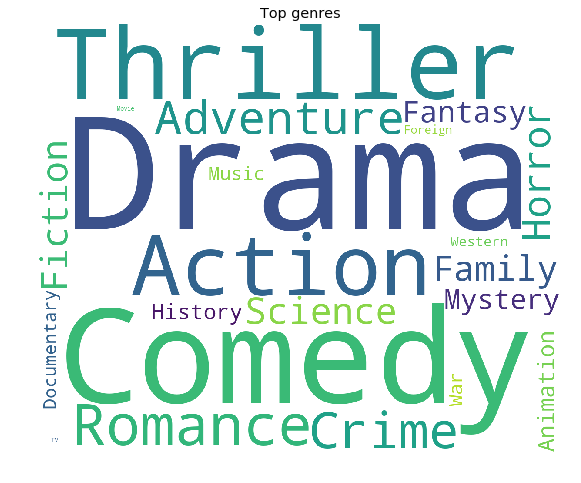

In [174]:
# Word Cloud
plt.figure(figsize = (12, 8))
text = ' '.join([i for j in genres_list for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top genres')
plt.axis("off")
plt.show()

In [ ]:
train['num_genres'] = train['genres'].apply(lambda x: len(x) if x != {} else 0)
train['all_genres'] = train['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(15)]
for g in top_genres:
    train['genre_' + g] = train['all_genres'].apply(lambda x: 1 if g in x else 0)
    
test['num_genres'] = test['genres'].apply(lambda x: len(x) if x != {} else 0)
test['all_genres'] = test['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_genres:
    test['genre_' + g] = test['all_genres'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['genres'], axis=1)
test = test.drop(['genres'], axis=1)